In [1]:
import argparse
import datetime
import os
import sys

import pytorch_lightning as pl
import torch
import wandb
from pytorch_lightning.loggers import WandbLogger
from uncertainy.radio import get_radio_data_loaders
from torch import nn
# Generate plot of the data
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
h = {  # hyperparameters
    'dataset': 'TOY_REGRESSION',  #'TOY_REGRESSION', 'RADIO',
    'dataset_path': '../data/',

    'in_channels': 2,
    'hidden_channels': 32,
    'epochs': 2,
    'learning_rate': 1e-4,
    'checkpoint_path': './saved_models',
    'batch_size': 128,
    'num_workers': 8,
    'train': False,  # Set this to false if you only want to evaluate the model

    'limit_train_batches': 1.0,
    'limit_val_batches': 1.0,
    'limit_test_batches': 1.0,

    'use_wandb': False,
    'wandb_project': 'uncertainty',
    'wandb_entity': 'oBoii',
    'wandb_name': 'radio',

    'fast_dev_run': True,
    'overfit_batches': None
}

In [3]:
# Check if the script is being run in a Jupyter notebook
if 'ipykernel' not in sys.modules:
    # Parse command-line arguments
    parser = argparse.ArgumentParser()
    for key, value in h.items():
        if isinstance(value, bool):
            parser.add_argument(f'--{key}', type=bool, default=value)
        elif isinstance(value, int):
            parser.add_argument(f'--{key}', type=int, default=value)
        elif isinstance(value, float):
            parser.add_argument(f'--{key}', type=float, default=value)
        else:  # for str and potentially other types
            parser.add_argument(f'--{key}', type=type(value), default=value)
    args = parser.parse_args()

    # Overwrite the default hyperparameters with the command-line arguments
    h.update(vars(args))

# In terminal, run:
# python main.py --model SinkhornConvNetV2 --epochs 30

In [4]:
# if h['model'] == 'Sink':
#     SinkhornConvNet = SinkhornConvNetV1
# elif h['model'] == 'SinkV2':
#     SinkhornConvNet = SinkhornConvNetV2
# elif h['model'] == 'SinkV3':
#     SinkhornConvNet = SinkhornConvNetV3
# else:
#     raise ValueError(f"Unknown model: {h['model']}")

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 64

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

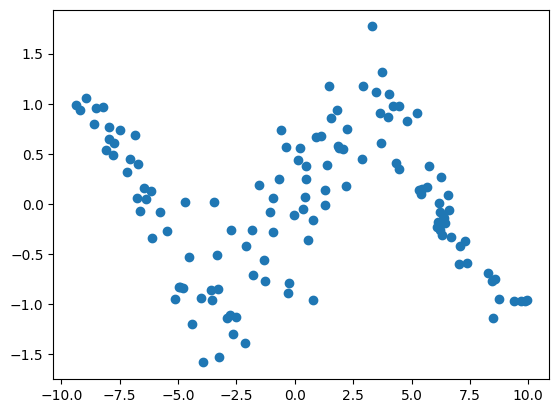

torch.Size([128]) torch.Size([128])


In [8]:
from uncertainy.toy_regression import get_toy_regression_data_loaders

if h['dataset'] == 'RADIO':
    train_loader, val_loader, test_loader = get_radio_data_loaders(
        all_datasets_path=h['dataset_path'],
        batch_size=h['batch_size'],
        num_workers=h['num_workers'])
elif h['dataset'] == 'TOY_REGRESSION':
    train_loader, val_loader, test_loader = get_toy_regression_data_loaders(
        batch_size=h['batch_size'],
        num_workers=h['num_workers'],
        num_points=1_000)

    x, y = next(iter(val_loader))
    plt.scatter(x, y)
    plt.show()
else:
    raise ValueError(f"Unknown dataset: {h['dataset']}")

In [103]:
class CustomCallbacks(pl.Callback):
    pass

#     def __init__(self, plot_every_n_epoch, num_pieces, wandb_logger: WandbLogger):
#         super().__init__()
#         self.plot_every_n_epoch = plot_every_n_epoch
#         self.num_pieces = num_pieces
#         self.wandb_logger = wandb_logger
# 
#     def assemble_image(self, pieces):
#         # pieces: [num_pieces, channels, height // num_pieces, width // num_pieces]
#         num_pieces, channels, piece_height, piece_width = pieces.shape
#         num_pieces_side = int(num_pieces ** 0.5)
# 
#         # Reshape to [num_pieces_side, num_pieces_side, channels, piece_height, piece_width]
#         pieces = pieces.view(num_pieces_side, num_pieces_side, channels, piece_height, piece_width)
# 
#         # Permute to [channels, num_pieces_side, piece_height, num_pieces_side, piece_width]
#         pieces = pieces.permute(2, 0, 3, 1, 4)
# 
#         # Reshape to [channels, height, width]
#         image = pieces.contiguous().view(channels, num_pieces_side * piece_height, num_pieces_side * piece_width)
# 
#         return image
# 
#     def log_images(self, trainer, pl_module, loader, prefix):
#         if (trainer.current_epoch % self.plot_every_n_epoch == 0) or (trainer.current_epoch == h['epochs'] - 1):
#             pl_module.eval()
#             image_batch, label_batch = next(iter(loader))
#             pieces, random_pieces, _ = batch_chunk_image(image_batch, self.num_pieces)
#             pieces, random_pieces = pieces.to(pl_module.device), random_pieces.to(pl_module.device)
# 
#             ordered_pieces, permutation_matrices = pl_module(random_pieces)
#             # Assemble the pieces into a single image before logging
#             nb_ims = min(ordered_pieces.shape[0], 10)
#             for i in range(nb_ims):
#                 initial_image = self.assemble_image(random_pieces[i])
#                 ordered_image = self.assemble_image(ordered_pieces[i])
#                 ground_truth_image = self.assemble_image(pieces[i])
# 
#                 # log to wandb
#                 self.wandb_logger.experiment.log(
#                     {f"{prefix}_predicted_image/img_{i}": wandb.Image(ordered_image.cpu().squeeze(),
#                                                                       caption=f"Label {label_batch[i]}"),
#                      f"{prefix}_ground_truth/img_{i}": wandb.Image(ground_truth_image.cpu().squeeze(),
#                                                                    caption=f"Label {label_batch[i]}"),
#                      f"{prefix}_input/img_{i}": wandb.Image(initial_image.cpu().squeeze(),
#                                                             caption=f"Label {label_batch[i]}")},
#                     step=trainer.global_step)
# 
#             pl_module.train()
# 
#     def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: SinkhornConvNet):
#         self.log_images(trainer, pl_module, train_loader, "TRAIN")
# 
#     def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: SinkhornConvNet):
#         pass
# 
#     def on_train_end(self, trainer, pl_module):
#         self.log_images(trainer, pl_module, test_loader, "TEST_SET_train_end")


In [104]:
# Initialize the model
model = SimpleNet()
if h['train']:
    if h['use_wandb']:
        date_identifier = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        wandb_logger = WandbLogger()
        wandb.init(project=h['wandb_project'],
                   config=h,
                   entity=h['wandb_entity'],
                   name=h['wandb_name'])

    trainer = pl.Trainer(
        max_epochs=h['epochs'],
        # callbacks=[CustomCallbacks(plot_every_n_epoch=1, num_pieces=h['num_pieces'],
        #                            wandb_logger=wandb_logger)] if h['use_wandb'] else None,
        # logger=wandb_logger if h['use_wandb'] else None,
        limit_train_batches=h['limit_train_batches'],
        limit_val_batches=h['limit_val_batches'],
        limit_test_batches=h['limit_test_batches'],
        fast_dev_run=h['fast_dev_run'],
        overfit_batches=h['overfit_batches'])

    # Train the model
    trainer.fit(model, train_loader, val_dataloaders=test_loader)

    # Save the model
    torch.save(model.state_dict(), os.path.join(h['checkpoint_path'], 'model.pth'))

    # Finish the run if we it was running
    if wandb.run is not None:
        wandb.finish()
